#### Friday, November 15, 2024

<strike>mamba activate rag_genai</strike>

mamba activate rag_genai_20241115

This notebook all runs in one pass.

In [ ]:
import os
print(os.environ['OPENAI_API_KEY'])
print(os.environ['ACTIVELOOP_TOKEN'])

In [ ]:
# Deliberately set the OPENAI_API_KEY to an invalid value to ensure that the code is not using it.
import os
os.environ['OPENAI_API_KEY'] = "Nope!"

#Multimodal Multimodular RAG for Drone Technology
copyright 2024, Denis Rothman

The goal of this educational notebook is to have a working understanding of how to build a RAG system that can process and understand both text and image data to answer questions about drone technology.

The program implements:

* Large Language Models (LLMs) to process and understand text about drones.
   
* Multimodal datasets containing images and labels of drones.
   
* Functions to display images and identify objects within them using bounding boxes.
   
* Builds a system that can answer questions about drone technology using both text and images.
   





# Installing the environment

Run the Deep Lake installation in the following cell first.

In [ ]:
#Google Drive option to store API Keys
#Store you key in a file and read it(you can type it directly in the notebook but it will be visible for somebody next to you)
# from google.colab import drive
# drive.mount('/content/drive')

*First run the following cells and restart Google Colab session if prompted. Then run the notebook again cell by cell to explore the code.*

In [ ]:
# !pip install llama-index-vector-stores-deeplake==0.1.6

In [ ]:
# !pip install deeplake==3.9.18

In [ ]:
# !pip install llama-index==0.10.64

In [ ]:
# !pip install llama-index-llms-openai==0.1.29

In [2]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document
from llama_index.vector_stores.deeplake import DeepLakeVectorStore

/home/rob/miniforge3/envs/rag_genai_20241115/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.2) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [ ]:
# !pip install sentence-transformers==3.0.1

In [ ]:
#Retrieving and setting the OpenAI API key
# f = open("drive/MyDrive/files/api_key.txt", "r")
# API_KEY=f.readline().strip()
# f.close()

# #The OpenAI KeyActiveloop and OpenAI API keys
# import os
# import openai
# os.environ['OPENAI_API_KEY'] =API_KEY
# openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
#Retrieving and setting the Activeloop API token
# f = open("drive/MyDrive/files/activeloop.txt", "r")
# API_token=f.readline().strip()
# f.close()
# ACTIVELOOP_TOKEN=API_token
# os.environ['ACTIVELOOP_TOKEN'] =ACTIVELOOP_TOKEN

In [ ]:
# For Google Colab and Activeloop while waiting for Activeloop (April 2024) pending new version
#This line writes the string "nameserver 8.8.8.8" to the file. This is specifying that the DNS server the system
#should use is at the IP address 8.8.8.8, which is one of Google's Public DNS servers.
# with open('/etc/resolv.conf', 'w') as file:
#    file.write("nameserver 8.8.8.8")

# Loading the LLM dataset

**Replace `hub://denis76/drone_v2` by your organization and dataset name**

In [3]:
! ls ../Chapter03/VectorStore/

dataset_lock.lock  embedding	     id        text
dataset_meta.json  _embedding_shape  metadata  version_control_info.json


In [4]:
# Here we want to load the dataset we created in Chapter 3
import deeplake
# dataset_path_llm = "hub://denis76/drone_v2"
dataset_path_llm = "../Chapter03/VectorStore/"
ds_llm = deeplake.load(dataset_path_llm)

../Chapter03/VectorStore/ loaded successfully.



In [5]:
import json
import pandas as pd
import numpy as np

# Create a dictionary to hold the data
data_llm = {}

# Iterate through the tensors in the dataset
for tensor_name in ds_llm.tensors:
    tensor_data = ds_llm[tensor_name].numpy()

    # Check if the tensor is multi-dimensional
    if tensor_data.ndim > 1:
        # Flatten multi-dimensional tensors
        data_llm[tensor_name] = [np.array(e).flatten().tolist() for e in tensor_data]
    else:
        # Convert 1D tensors directly to lists and decode text
        if tensor_name == "text":
            data_llm[tensor_name] = [t.tobytes().decode('utf-8') if t else "" for t in tensor_data]
        else:
            data_llm[tensor_name] = tensor_data.tolist()

# Create a Pandas DataFrame from the dictionary
df_llm = pd.DataFrame(data_llm)
df_llm

embedding  \
0   [0.0009606288513168693, 0.006392387207597494, ...   
1   [-0.012029143050312996, 0.0163202416151762, 0....   
2   [-0.013978586532175541, -0.001981638604775071,...   
3   [-0.0022504113148897886, -0.001079589128494262...   
4   [-0.017446326091885567, -0.0008095360244624317...   
..                                                ...   
82  [-0.010708412155508995, -0.011701422743499279,...   
83  [-0.01298088114708662, -0.013558114878833294, ...   
84  [-0.012997124344110489, -0.011900407262146473,...   
85  [-0.013722202740609646, -0.007609154097735882,...   
86  [-0.018510082736611366, 0.00045911301276646554...   

                                        id  \
0   [d0de5799-f7a2-466b-a2a2-d8d08b9786d7]   
1   [af5999ff-9b03-4384-8b37-994e486313e5]   
2   [824b1429-592e-4845-ad46-813152ab22e6]   
3   [cc72e208-70e9-43ad-96ac-a667383f105e]   
4   [1cdf469a-8bd0-4625-ae09-e5ee6bc424eb]   
..                                     ...   
82  [350abb2f-f4da-41d8-ae53-4d54477f714f]   
83  [92b45f14-18c3-4030-89bb-03a9bb61dac3]   
84  [cbc97fa2-5a6e-492d-9c2f-d52974b6b5a1]   
85  [18fafab1-edc7-4c42-a3cd-ffbd58022d37]   
86  [da826bc5-89ba-472e-bc2f-f63c5b6cd0e5]   

                                             metadata  \
0   [{'file_path': '/home/rob/Data/Documents/Githu...   
1   [{'file_path': '/home/rob/Data/Documents/Githu...   
2   [{'file_path': '/home/rob/Data/Documents/Githu...   
3   [{'file_path': '/home/rob/Data/Documents/Githu...   
4   [{'file_path': '/home/rob/Data/Documents/Githu...   
..                                                ...   
82  [{'file_path': '/home/rob/Data/Documents/Githu...   
83  [{'file_path': '/home/rob/Data/Documents/Githu...   
84  [{'file_path': '/home/rob/Data/Documents/Githu...   
85  [{'file_path': '/home/rob/Data/Documents/Githu...   
86  [{'file_path': '/home/rob/Data/Documents/Githu...   

                                                 text  
0   [High Energy Physics  Theory arXiv1804.06985 h...  
1   [Computer Science  Computer Vision and Pattern...  
2   [Computerized information extraction from imag...  
3   [These include the concept of scalespace  the ...  
4   [Also some of the learningbased methods develo...  
..                                                ...  
82  [The application of small unmanned aerial syst...  
83  [ISSN 16747755 .  Peterman V. 26 August 2015. ...  
84  [Medina Jennifer 19 July 2015. Chasing Video W...  
85  [Formation Control for UAVs Using a Flux Guide...  
86  [Lightning Bugs  Buffalo Hunters The Ryan Mode...  

[87 rows x 4 columns]

In [6]:
# Ensure 'text' column is of type string
df_llm['text'] = df_llm['text'].astype(str)
# Create documents with IDs
documents_llm = [Document(text=row['text'], doc_id=str(row['id'])) for _, row in df_llm.iterrows()]

## Initializing the LLM Query Engine

(If the OpenAI key is wrong, then the next cell will fail ...)

In [7]:
from llama_index.core import VectorStoreIndex
# OpenAI key needs to be valid for this to work ... hmm and there is some usage!
vector_store_index_llm = VectorStoreIndex.from_documents(documents_llm)

# 1.6s 

In [8]:
vector_query_engine_llm = vector_store_index_llm.as_query_engine(similarity_top_k=2, temperature=0.1, num_output=1024)

# 0.0 s

### User input for multimodular modular RAG

Modular RAG with multiple modalities (text, images) and sources of information; in this case, two datasets.

In [9]:
user_input="How do drones identify a truck?"

In [10]:
import time
import textwrap

#start the timer
start_time = time.time()
llm_response = vector_query_engine_llm.query(user_input)
# Stop the timer
end_time = time.time()

# Calculate and print the execution time
elapsed_time = end_time - start_time

print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(llm_response), 100))

Query execution time: 0.9665 seconds
Drones can identify a truck using visual detection and tracking capabilities, often utilizing deep
neural networks for performance benchmarking.


# Loading and visualizing the multimodal dataset



In [11]:
import deeplake

dataset_path = 'hub://activeloop/visdrone-det-train'
ds = deeplake.load(dataset_path) # Returns a Deep Lake Dataset but does not download data locally

# 6.0s

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/visdrone-det-train



|

hub://activeloop/visdrone-det-train loaded successfully.



In [12]:
ds.summary()

Dataset(path='hub://activeloop/visdrone-det-train', read_only=True, tensors=['boxes', 'images', 'labels'])

 tensor      htype                 shape               dtype  compression
 -------    -------               -------             -------  ------- 
  boxes      bbox            (6471, 1:914, 4)         float32   None   
 images      image     (6471, 360:1500, 480:2000, 3)   uint8    jpeg   
 labels   class_label          (6471, 1:914)          uint32    None   


In [13]:
ds.visualize()

HINT: Please forward the port - 58187 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


In [ ]:
import pandas as pd

# Create an empty DataFrame with the defined structure
df = pd.DataFrame(columns=['image', 'boxes', 'labels'])

# Iterate through the samples using enumerate
for i, sample in enumerate(ds):

    # Image data (choose either path or compressed representation)
    # df.loc[i, 'image'] = sample.images.path  # Store image path
    df.loc[i, 'image'] = sample.images.tobytes()  # Store compressed image data

    # Bounding box data (as a list of lists)
    boxes_list = sample.boxes.numpy(aslist=True)
    df.loc[i, 'boxes'] = [box.tolist() for box in boxes_list]

    # Label data (as a list)
    label_data = sample.labels.data()
    df.loc[i, 'labels'] = label_data['text']

df

# 2m 54.6 s
# 2m 42.2 s

image  \
0     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
...                                                 ...   
6466  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6467  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6468  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6469  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6470  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

                                                  boxes  \
0     [[1221.0, 84.0, 16.0, 33.0], [1235.0, 71.0, 18...   
1     [[351.0, 936.0, 305.0, 114.0], [0.0, 818.0, 22...   
2     [[699.0, 716.0, 26.0, 54.0], [600.0, 604.0, 22...   
3     [[417.0, 77.0, 57.0, 54.0], [387.0, 109.0, 31....   
4     [[794.0, 617.0, 97.0, 115.0], [803.0, 539.0, 7...   
...                                                 ...   
6466  [[683.0, 710.0, 7.0, 6.0], [681.0, 717.0, 5.0,...   
6467  [[1761.0, 676.0, 207.0, 155.0], [1539.0, 648.0...   
6468  [[0.0, 501.0, 105.0, 93.0], [412.0, 594.0, 172...   
6469  [[200.0, 604.0, 112.0, 64.0], [311.0, 560.0, 1...   
6470  [[60.0, 144.0, 16.0, 21.0], [51.0, 120.0, 15.0...   

                                                 labels  
0     [pedestrian, pedestrian, tricycle, pedestrian,...  
1     [car, car, car, car, car, car, car, car, car, ...  
2     [truck, car, van, car, car, car, car, car, car...  
3     [ignored regions, ignored regions, car, car, c...  
4     [car, car, car, car, car, car, car, car, car, ...  
...                                                 ...  
6466  [car, car, car, car, awning-tricycle, car, car...  
6467  [car, car, car, car, car, van, car, car, car, ...  
6468  [car, van, pedestrian, pedestrian, pedestrian,...  
6469  [van, truck, van, car, car, van, others, car, ...  
6470  [people, pedestrian, others, people, people, m...  

[6471 rows x 3 columns]

In [15]:
labels_list = ds.labels.info['class_names']
labels_list

['ignored regions',
 'pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor',
 'others']

# Navigating the multimodal dataset structure

## Selecting an image

In [16]:
# choose an image
ind=0
image = ds.images[ind].numpy() # Fetch the first image and return a numpy array

In [17]:
import deeplake
from IPython.display import display
from PIL import Image
import cv2  # Import OpenCV

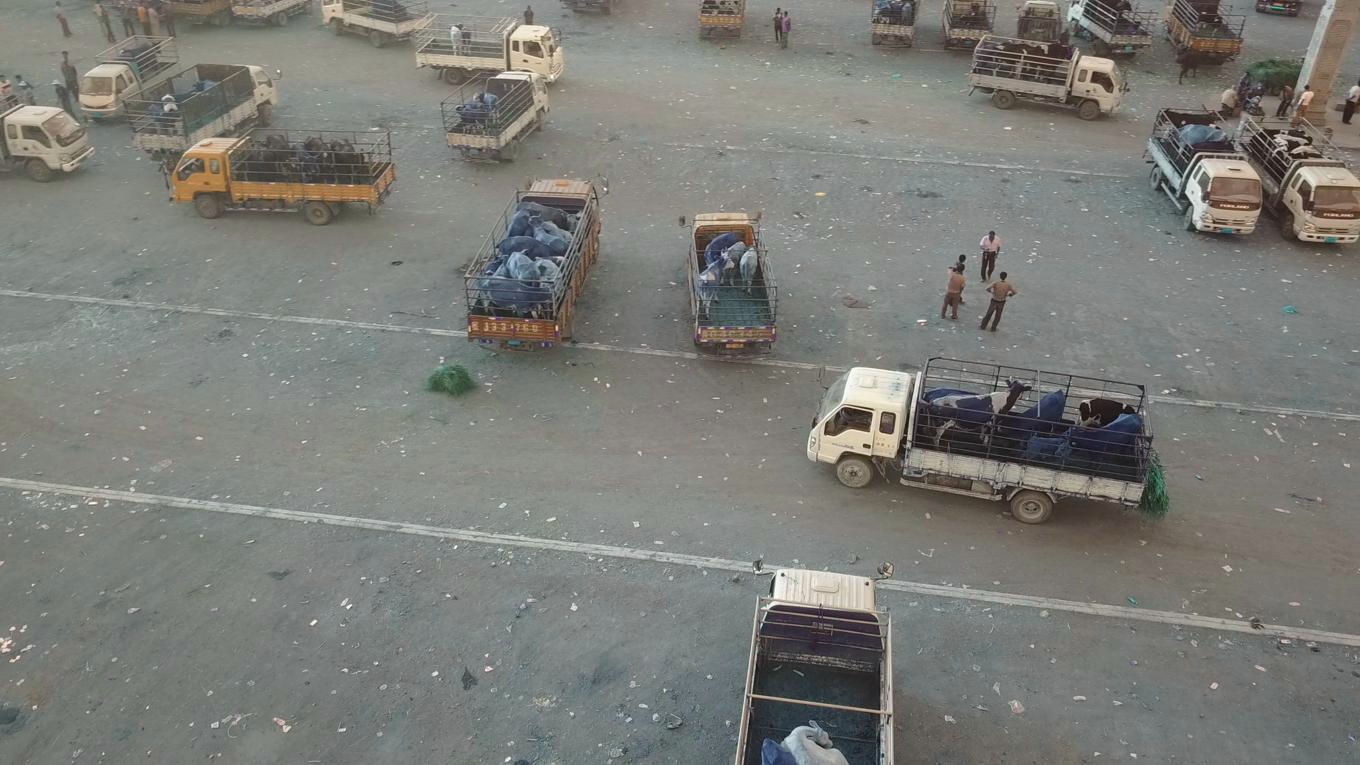

In [18]:
image = ds.images[0].numpy()

# Convert from BGR to RGB (if necessary)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create PIL Image and display
img = Image.fromarray(image_rgb)
display(img)

## Adding Bounding boxes and saving the image

In [19]:
labels = ds.labels[ind].data() # Fetch the labels in the selected image
print(labels)

{'value': array([1, 1, 7, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6,
       1, 1, 1, 1, 1, 1, 6, 6, 3, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 6, 6, 6], dtype=uint32), 'text': ['pedestrian', 'pedestrian', 'tricycle', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'pedestrian', 'truck', 'truck', 'truck', 'truck', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'truck', 'truck', 'bicycle', 'truck', 'truck', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'truck', 'truck', 'truck']}


In [20]:
values = labels['value']
text_labels = labels['text']

# Determine the maximum text label length for formatting
max_text_length = max(len(label) for label in text_labels)

# Print the header
print(f"{'Index':<10}{'Label':<{max_text_length + 2}}")
print("-" * (10 + max_text_length + 2))  # Add a separator line

# Print the indices and labels in two columns
for index, label in zip(values, text_labels):
    print(f"{index:<10}{label:<{max_text_length + 2}}")

Index     Label       
----------------------
1         pedestrian  
1         pedestrian  
7         tricycle    
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
1         pedestrian  
6         truck       
6         truck       
6         truck       
6         truck       
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
6         truck       
6         truck       
3         bicycle     
6         truck       
6         truck       
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         p

In [21]:
ds.labels[ind].info['class_names'] # class names of the selected image

['ignored regions',
 'pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor',
 'others']

In [22]:
def display_image_with_bboxes(image_data, bboxes, labels, label_name, ind=0):
    #Displays an image with bounding boxes for a specific label.

    image_bytes = io.BytesIO(image_data)
    img = Image.open(image_bytes)

    # Extract class names specifically for the selected image
    class_names = ds.labels[ind].info['class_names']

    # Filter for the specific label (or display all if class names are missing)
    if class_names is not None:
        try:
            label_index = class_names.index(label_name)
            relevant_indices = np.where(labels == label_index)[0]
        except ValueError:
            print(f"Warning: Label '{label_name}' not found. Displaying all boxes.")
            relevant_indices = range(len(labels))
    else:
        relevant_indices = []  # No labels found, so display no boxes

    # Draw bounding boxes
    draw = ImageDraw.Draw(img)
    for idx, box in enumerate(bboxes):  # Enumerate over bboxes
        if idx in relevant_indices:   # Check if this box is relevant
            x1, y1, w, h = box
            x2, y2 = x1 + w, y1 + h
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1), label_name, fill="red")
    # Save the image
    save_path="boxed_image.jpg"
    img.save(save_path)
    display(img)


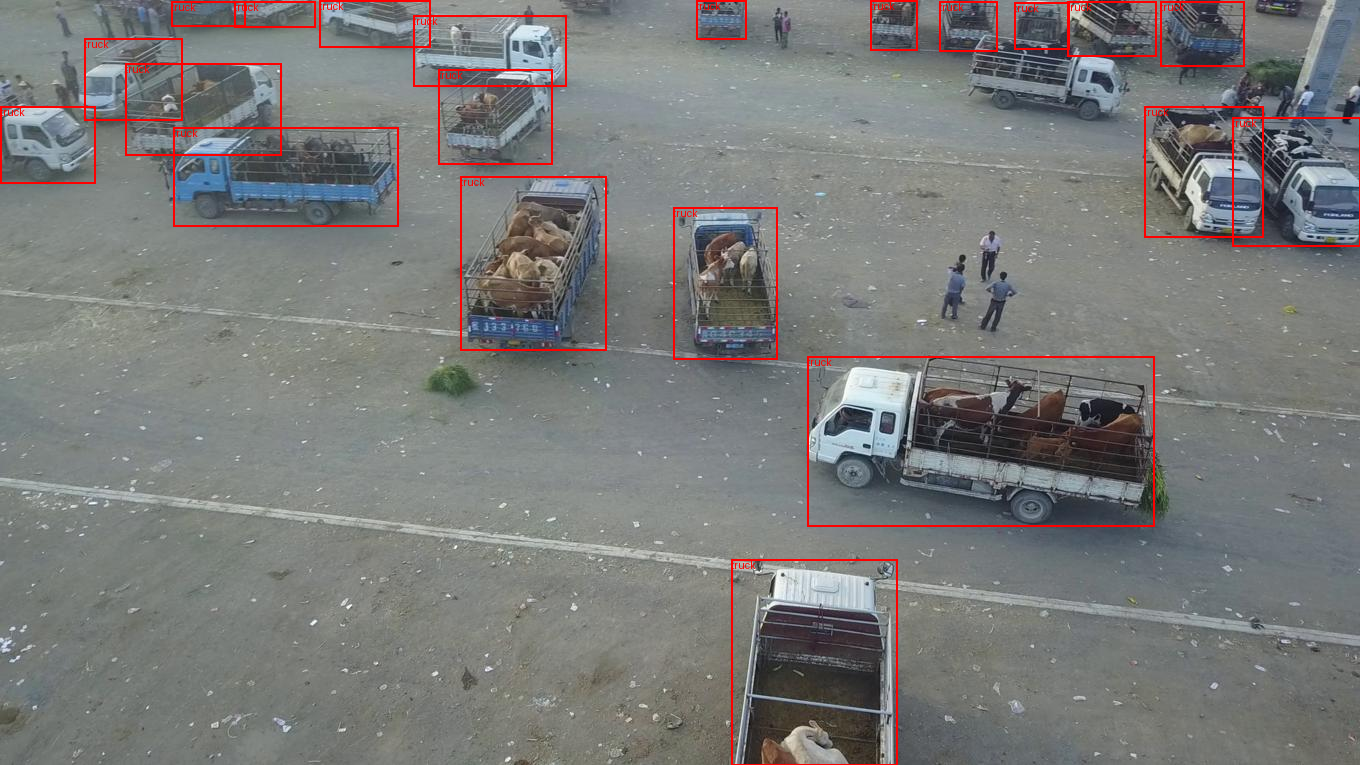

In [23]:
import io
from PIL import ImageDraw
# Fetch labels and image data for the selected image
labels = ds.labels[ind].data()['value']
image_data = ds.images[ind].tobytes()
bboxes = ds.boxes[ind].numpy()
ibox="truck" # class in image

# Display the image with bounding boxes for the label chosen
display_image_with_bboxes(image_data, bboxes, labels, label_name=ibox)

# Building a multimodal search engine

In [24]:
# The DataFrame is named 'df'
df['doc_id'] = df.index.astype(str)  # Create unique IDs from the row indices

# Create documents (extract relevant text for each image's labels)
documents = []
for _, row in df.iterrows():
    text_labels = row['labels'] # Each label is now a string
    text = " ".join(text_labels) # Join text labels into a single string
    document = Document(text=text, doc_id=row['doc_id'])
    documents.append(document)

In [ ]:
from llama_index.core import VectorStoreIndex
vector_store_index = VectorStoreIndex.from_documents(documents)

# 59.4 seconds

In [26]:
vector_store_index.index_struct

IndexDict(index_id='123dae2b-ed4d-430b-bc96-2c7b5f38428c', summary=None, nodes_dict={'3b737bc2-558e-4b7d-bea6-8a88b2c3eee0': '3b737bc2-558e-4b7d-bea6-8a88b2c3eee0', '461e8585-0023-4e04-b0f2-6f3c0d8acdce': '461e8585-0023-4e04-b0f2-6f3c0d8acdce', '4beb3d24-564f-448e-8135-ecfdffc0a5ef': '4beb3d24-564f-448e-8135-ecfdffc0a5ef', '95644be4-021c-44e6-8086-91b192fe91c9': '95644be4-021c-44e6-8086-91b192fe91c9', 'bfb33b2e-ae2a-4920-a7c0-7eb5574353e4': 'bfb33b2e-ae2a-4920-a7c0-7eb5574353e4', '258fecae-e951-4bc2-b588-dcee85b9635d': '258fecae-e951-4bc2-b588-dcee85b9635d', '8a49dfe1-6119-40ff-8b54-5334aec9286c': '8a49dfe1-6119-40ff-8b54-5334aec9286c', '964bf1e3-94fd-414f-b8ba-1485aaef726c': '964bf1e3-94fd-414f-b8ba-1485aaef726c', '626daf37-be50-4100-a6c6-98ac3089694f': '626daf37-be50-4100-a6c6-98ac3089694f', 'b29f85fc-a9ce-464e-8344-1b2cf8e73bf8': 'b29f85fc-a9ce-464e-8344-1b2cf8e73bf8', 'd30a8360-bb0a-4c98-9ebd-4897084702db': 'd30a8360-bb0a-4c98-9ebd-4897084702db', '956a7247-203d-4509-9af0-be78acfddb

In [27]:
vector_query_engine = vector_store_index.as_query_engine(similarity_top_k=1, temperature=0.1, num_output=1024)

In [28]:
import time

start_time = time.time()
response = vector_query_engine.query(user_input)
# Stop the timer
end_time = time.time()

# Calculate and print the execution time
elapsed_time = end_time - start_time

print(f"Query execution time: {elapsed_time:.4f} seconds")

Query execution time: 0.9961 seconds


In [29]:
print(textwrap.fill(str(response), 100))

Drones use various sensors such as cameras, LiDAR, and GPS to identify and track objects like
trucks.


In [30]:
from itertools import groupby

def get_unique_words(text):
    text = text.lower().strip()
    words = text.split()
    unique_words = [word for word, _ in groupby(sorted(words))]
    return unique_words

for node in response.source_nodes:
    print(node.node_id)
    # Get unique words from the node text:
    node_text = node.get_text()
    unique_words = get_unique_words(node_text)
    print("Unique Words in Node Text:", unique_words)

e11bc16e-8b6f-4f3a-92a2-7fe00d3dea9e
Unique Words in Node Text: ['truck']


In [33]:
!ls

Multimodal_Modular_RAG_Drones.ipynb


In [32]:
# deleting any image prevsiously saved
!rm boxed_image.jpg

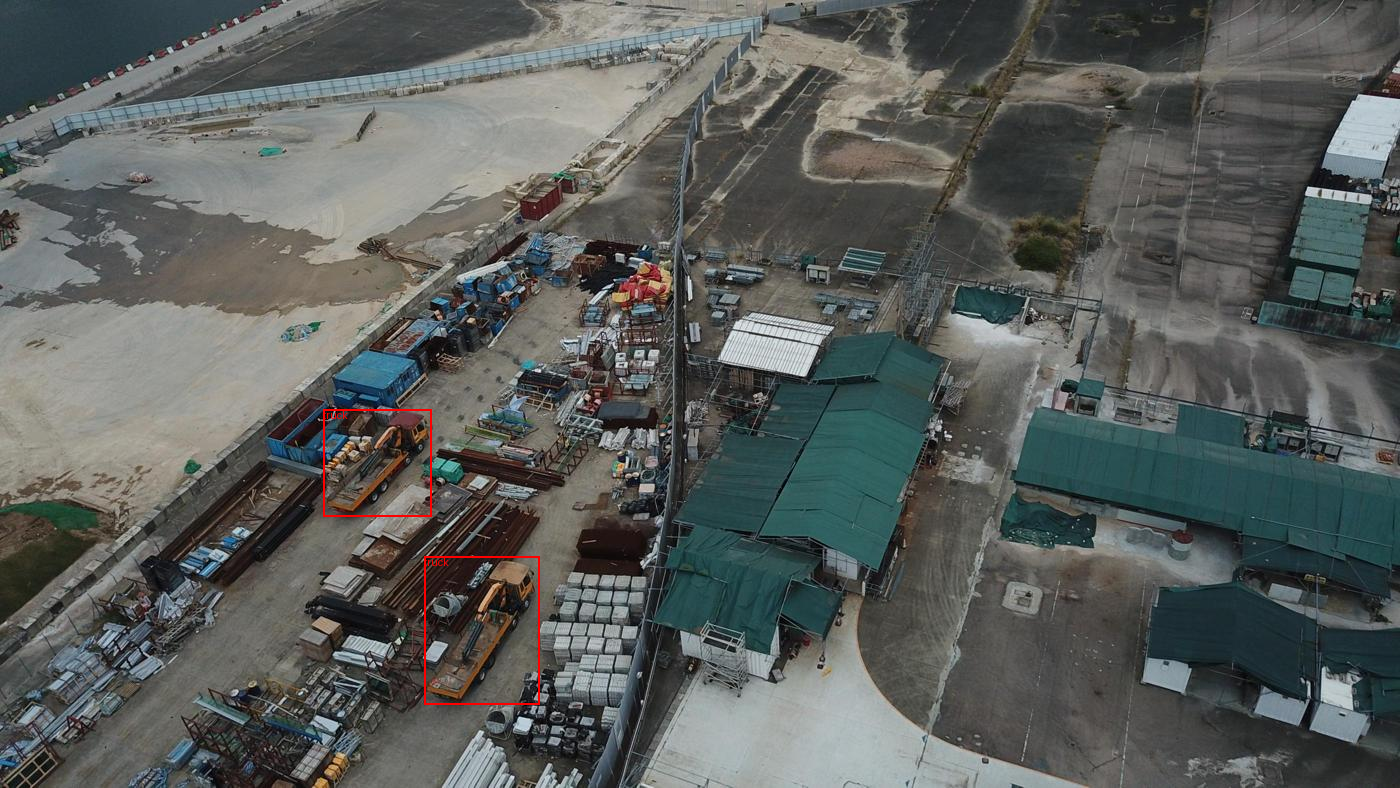

In [34]:
import io
from PIL import Image

def process_and_display(response, df, ds, unique_words):
    """Processes nodes, finds corresponding images in dataset, and displays them with bounding boxes.

    Args:
        response: The response object containing source nodes.
        df: The DataFrame with doc_id information.
        ds: The dataset containing images, labels, and boxes.
        unique_words: The list of unique words for filtering.
    """

    for i, sample in enumerate(ds):
        for node in response.source_nodes:
            related_node_info = next(iter(node.node.relationships.values()))
            original_doc_id = related_node_info.node_id

            try:
                row_index = df[df['doc_id'] == original_doc_id].index[0]
            except IndexError:
                continue  # Skip if doc_id not found in the DataFrame

            if i == row_index:
                image_bytes = io.BytesIO(sample.images.tobytes())
                img = Image.open(image_bytes)

                labels = ds.labels[i].data()['value']
                image_data = ds.images[i].tobytes()
                bboxes = ds.boxes[i].numpy()
                ibox = unique_words[0]  # class in image

                display_image_with_bboxes(image_data, bboxes, labels, label_name=ibox)

# Assuming you have your 'response', 'df', 'ds', and 'unique_words' objects prepared:
process_and_display(response, df, ds, unique_words)

# Multimodal Modular Summary

Assuming the processes have been activated.

In [35]:
from PIL import Image
def display_source_image(image_path):
  try:
    with Image.open(image_path) as img:
        display(img)
  except FileNotFoundError:
    print("Error: The image file was not found at the specified path.")
  except Exception as e:  # Catch other potential errors
    print(f"Error loading image: {e}")

In [36]:
# 1.user input=user_input
print(user_input)

# 2.LLM response
print(textwrap.fill(str(llm_response), 100))

How do drones identify a truck?
Drones can identify a truck using visual detection and tracking capabilities, often utilizing deep
neural networks for performance benchmarking.


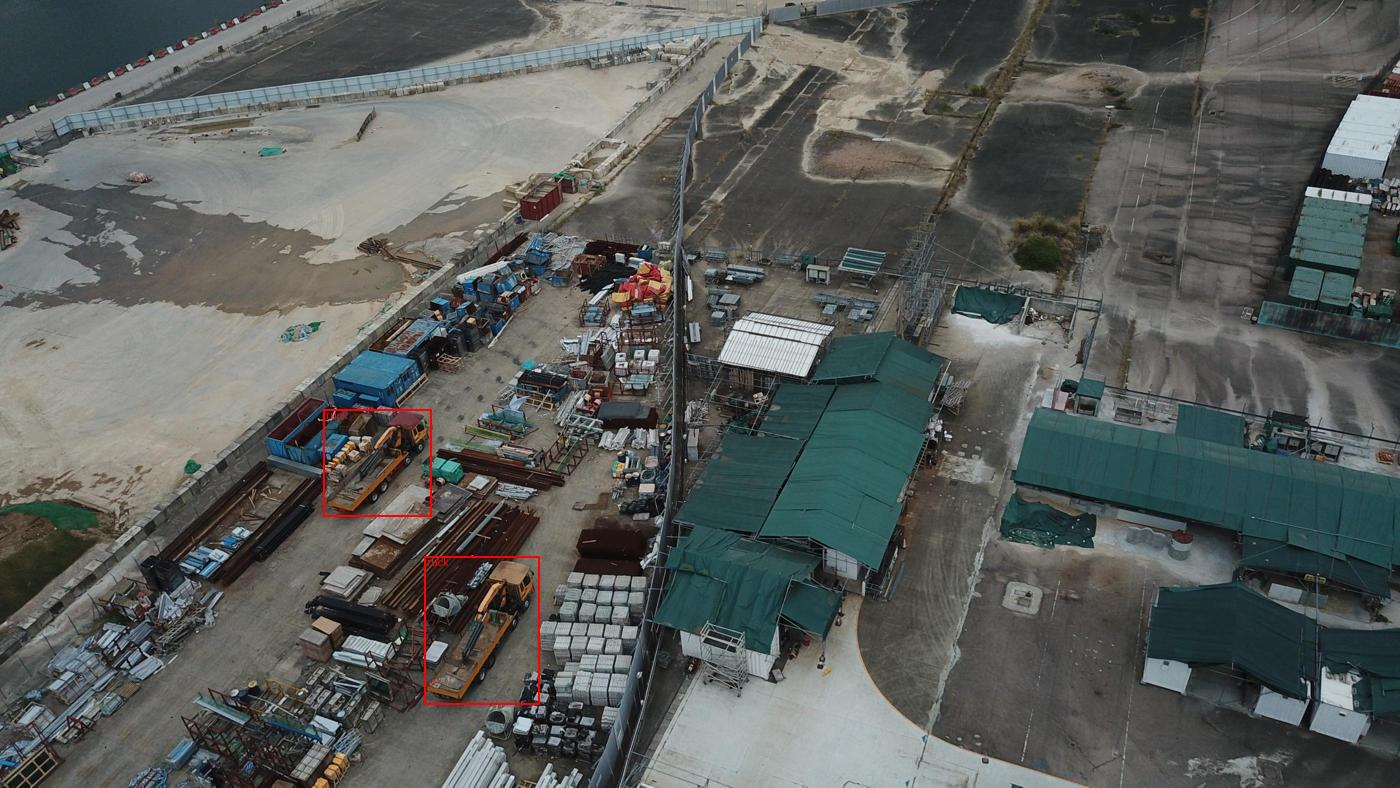

In [38]:
# 3.Multimodal reponse
image_path = "boxed_image.jpg"
display_source_image(image_path)

# Performance metric

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_cosine_similarity_with_embeddings(text1, text2):
    embeddings1 = model.encode(text1)
    embeddings2 = model.encode(text2)
    similarity = cosine_similarity([embeddings1], [embeddings2])
    return similarity[0][0]

## LLM performance

In [41]:
llm_similarity_score = calculate_cosine_similarity_with_embeddings(user_input, str(llm_response))
print(user_input)
print(llm_response)
print(f"Cosine Similarity Score: {llm_similarity_score:.3f}")

How do drones identify a truck?
Drones can identify a truck using visual detection and tracking capabilities, often utilizing deep neural networks for performance benchmarking.
Cosine Similarity Score: 0.677


## Multimodal performance

In [42]:
import base64

IMAGE_PATH = "boxed_image.jpg"

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

In [43]:
from openai import OpenAI

#Set the API key for the client
# client = OpenAI(api_key=openai.api_key)
# MODEL="gpt-4o"
client = OpenAI()
MODEL="gpt-3.5-turbo"


In [46]:
MODEL="gpt-4o"


In [44]:
u_word=unique_words[0]
print(u_word)

truck


In [ ]:
# This code does not run if we use the gpt-3.5-turbo model
response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": f"You are a helpful assistant that analyzes images that contain {u_word}."},
        {"role": "user", "content": [
            {"type": "text", "text": f"Analyze the following image, tell me if there is one {u_word} or more in the bounding boxes and analyse them:"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ],
    temperature=0.0,
)
response_image = response.choices[0].message.content
print(response_image)

The image shows two trucks within the red bounding boxes. Both trucks appear to be flatbed trucks, likely used for transporting materials. They are parked in an industrial or construction area, surrounded by various equipment and supplies.


In [48]:
resp=user_input+u_word+"s"
multimodal_similarity_score = calculate_cosine_similarity_with_embeddings(resp, str(response_image))
print(f"Cosine Similarity Score: {multimodal_similarity_score:.3f}")

Cosine Similarity Score: 0.485


## Multimodal Modular RAG performance

In [49]:
score=(llm_similarity_score+multimodal_similarity_score)/2
print(f"Multimodal, Modular Score: {score:.3f}")

Multimodal, Modular Score: 0.581
